In [3]:
#processing
import pandas as pd
import scikitplot as skplt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from pandas import ExcelWriter
import scipy
scaler = StandardScaler()
#sql
import pymysql.cursors
#NLP
import nltk
import re
import pymorphy2
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.stem.snowball import RussianStemmer
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#warnings
import warnings
warnings.filterwarnings('ignore')
#visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)
%matplotlib inline
#vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#model
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
#classificators
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
import IDF
from xgboost.sklearn import XGBClassifier

In [4]:
#Подключиться к базе данных
def con():
    conn = pymysql.connect(host='192.168.64.1', port=3306, user='i.serov', password='X3*1Uy(F', db='mysql')
    return conn

In [9]:
%%time
df = pd.read_sql('''
SELECT
  c.id as credit_id,
  c.date_requested,
  if(c.status in ('ACTIVE', 'COMPLETED', 'EXPIRED', 'SOLD'), 1, 0) as is_accepted,
  c.status,
                  ifnull(IF(c.status IN ('active','completed','expired'),
                  (SELECT
                    IF((COUNT(credit_payment.id) > 0 OR CURDATE() < LEAST(c.due_date,DATE(c.date_received) + INTERVAL 31 DAY) + INTERVAL 16 DAY),0,1)
                  FROM br_release_moneyman.credit_payment
                  WHERE ((credit_payment.credit_id = c.id) AND (credit_payment.payment_date <(LEAST(c.due_date,DATE(c.date_received) + INTERVAL 31 DAY) + INTERVAL 16 DAY)))),NULL),0)
                  AS npl15,
  vr.*,
  va.*,
  vi.*,
  vo.*,
  vd.*,
  vam.*
FROM
  br_release_moneyman.credit c 
  INNER JOIN br_release_moneyman.borrower b on b.id = c.borrower_id
  INNER JOIN br_release_moneyman.verumview_report vr on vr.user_account_id=b.user_account_id
  LEFT JOIN br_release_moneyman.verumview_addressmatch va on vr.id = va.verumview_report_id
  LEFT JOIN br_release_moneyman.verumview_income vi on vr.id = vi.verumview_report_id
  LEFT JOIN br_release_moneyman.verumview_overduebills vo on vr.id = vo.verumview_report_id
  LEFT JOIN (
              SELECT
                Count(DISTINCT id) as cnt_id,
                sum(number_of_msgs) as number_of_msgs,
                min(days_since_last_msg) as min_days_since_last_msg,
                min(domain_name) as min_name,
                verumview_report_id
              FROM
                br_release_moneyman.verumview_dispute
              GROUP BY
                verumview_report_id) vd
      on vr.id = vd.verumview_report_id
  LEFT JOIN (
              SELECT
                sum(spend_amount) as sum_spend_amount,
                sum(transactions) as sum_transactions,
                #count_transactions
                sum(if(months_back=5, transactions, 0)) as cnt_Trans_5,
                sum(if(months_back=4, transactions, 0)) as cnt_Trans_4,
                sum(if(months_back=3, transactions, 0)) as cnt_Trans_3,
                sum(if(months_back=2, transactions, 0)) as cnt_Trans_2,
                sum(if(months_back=1, transactions, 0)) as cnt_Trans_1,
                sum(if(months_back=0, transactions, 0)) as cnt_Trans_0,
                #sum_transactions
                sum(if(months_back=5, spend_amount, 0)) as sum_Trans_5,
                sum(if(months_back=4, spend_amount, 0)) as sum_Trans_4,
                sum(if(months_back=3, spend_amount, 0)) as sum_Trans_3,
                sum(if(months_back=2, spend_amount, 0)) as sum_Trans_2,
                sum(if(months_back=1, spend_amount, 0)) as sum_Trans_1,
                sum(if(months_back=0, spend_amount, 0)) as sum_Trans_0,
                verumview_report_id
              FROM
                br_release_moneyman.verumview_amount
              GROUP BY
                verumview_report_id) vam
      on vr.id = vam.verumview_report_id
where c.date_requested>'2017-06-01' and c.date_requested<'2018-02-01' 
#WHERE c.status in ('ACTIVE', 'COMPLETED', 'EXPIRED', 'SOLD', 'CANCELLED');
''', con=con())

Wall time: 9.88 s


In [10]:
df.value_coun

,credit_id,date_requested,is_accepted,status,npl15,id,customer_uniq_id,customer_email,name,name_match,...,cnt_Trans_2,cnt_Trans_1,cnt_Trans_0,sum_Trans_5,sum_Trans_4,sum_Trans_3,sum_Trans_2,sum_Trans_1,sum_Trans_0,verumview_report_id
0,51521,2017-06-16 16:39:12,0,CANCELLED,0,1,e44d847a-61b5-4463-9be6-32072bfb8171,laisbermann@hotmail.com,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52620,2017-06-19 13:47:55,0,CANCELLED,0,1,e44d847a-61b5-4463-9be6-32072bfb8171,laisbermann@hotmail.com,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,52696,2017-06-19 14:40:14,0,CANCELLED,0,1,e44d847a-61b5-4463-9be6-32072bfb8171,laisbermann@hotmail.com,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,51541,2017-06-16 16:56:41,0,CANCELLED,0,4,659e9a48-2c19-47f1-9c00-4664314beb22,aislan195@gmail.com,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59252,2017-07-05 23:42:53,0,CANCELLED,0,4,659e9a48-2c19-47f1-9c00-4664314beb22,aislan195@gmail.com,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,51564,2017-06-16 17:15:05,0,CANCELLED,0,7,8af2bb20-7ebb-4727-acb4-06fe47dc35e7,Aparecidomarcos357@gmail.com,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,53724,2017-06-20 20:45:24,0,CANCELLED,0,7,8af2bb20-7ebb-4727-acb4-06fe47dc35e7,Aparecidomarcos357@gmail.com,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,65934,2017-07-19 22:48:51,0,CANCELLED,0,7,8af2bb20-7ebb-4727-acb4-06fe47dc35e7,Aparecidomarcos357@gmail.com,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,51560,2017-06-16 17:12:14,0,CANCELLED,0,9,0698f8f0-c13a-4316-91f0-8ebce401d011,Jaysonfernandes3@gmail.com,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,51567,2017-06-16 17:17:33,0,CANCELLED,0,9,0698f8f0-c13a-4316-91f0-8ebce401d011,Jaysonfernandes3@gmail.com,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df

In [155]:
df1 = df.copy()

In [156]:
df_accepted = df[df.is_accepted == 1].drop(['is_accepted', 'status'], axis = 1)
df_declined = df[df.is_accepted == 0].drop(['is_accepted', 'status'], axis = 1)

In [157]:
df = df_accepted.copy()

In [158]:
df.npl15.value_counts()

0    853
1    511
Name: npl15, dtype: int64

# Preprocessing Functions

In [159]:
# FIND SUMM OF DIGITS IN ROW
def sum_of_digits(x):
    try:
        return (sum([int(i) for i in re.findall('\d+', x)]))
    except:
        return 0


# WHAT CREDIT DID THE PERSON TAKE


def what_credit(x):
    try:
        if x.find('moneyman') != -1:
            return 12
        elif x.find('easycredito') != -1:
            return 11
        elif x.find('bompracredito') != -1:
            return 10
        elif x.find('lendico') != -1:
            return 9
        elif x.find('simplic') != -1:
            return 8
        elif x.find('justonline') != -1:
            return 7
        elif x.find('credbel') != -1:
            return 6
        elif x.find('trigg') != -1:
            return 5
        elif x.find('creditas') != -1:
            return 4
        elif x.find('geru') != -1:
            return 3
        elif x.find('ferratum') != -1:
            return 2
        else:
            return 1
    except:
        return 0

# FULL PREPROCESSING
def preproc(df):
    df.drop(
        [
            'id', 'date_requested', 'customer_uniq_id', 'user_account_id',
            'verumview_report_id', 'currency', 'date_recieved', 'name'
        ],
        axis=1,
        inplace=True)
    df.drop_duplicates(inplace=True)

    df['name_match'] = df['name_match'].map({
        'PartialMatchFirst': 1,
        'PartialMatchLast': 1,
        'MatchLastOnly': 2,
        'MatchFirstOnly': 2,
        'FullNameMatch': 3
    })
    df['mail_age_attribute'] = df['mail_age_attribute'].map({
        'New': 1,
        'Young': 2,
        'Medium': 3,
        'Old': 4
    })
    df['mail_earliest'] = df['mail_earliest'].map({
        'New': 1,
        'Young': 2,
        'Medium': 3,
        'Reliable': 4
    })
    df['mail_reliability'] = df['mail_reliability'].map({
        'Suspicious': 1,
        'LowUseInbox': 2,
        'Reliable': 3,
        'Trusted': 4
    })
    df['is_online_shopper'] = df['is_online_shopper'].map({
        'OfflineShopper': 1,
        'CasualShopper': 2,
        'MediumShopper': 3,
        'HeavyShopper': 4
    })
    df['mail_match'] = df['mail_match'].map({
        'No Match': 1,
        'DomainMatchOnly': 2,
        'UsernameMatchOnly': 3,
        'EmailMatched': 4
    })
    df['match_type'] = df['match_type'].map({
        'No PostcodeMatch': 1,
        'CityAndStreetMatch': 2,
        'FullMatch': 3
    })
    df['cv_attribute'] = pd.isnull(df['cv_attribute']).replace(True, 1)
    df['job_title'] = pd.isnull(df['job_title']).replace(True, 1)
    df['company'] = pd.isnull(df['company']).replace(True, 1)
    df['customer_email'] = df.customer_email.map(lambda x: x.split("@", 1)[1])
    df['customer_email'] = df['customer_email'].map(lambda x: 1 if x.find('gmail.com') != -1 
                                                    else (2 if x.find('hotmail.com') != -1 
                                                          else (3 if x.find('outlook.com') != -1 
                                                               else (4 if x.find('live.com') != -1 else 5))))
    
    df['prev_payday_loat_count'] = df.prev_payday_loat_taker.map(
        lambda x: sum_of_digits(x))
    df.prev_payday_loat_taker = df.prev_payday_loat_taker.map(
        lambda x: what_credit(x))
    df.fillna(0, inplace=True)
    df.index = range(len(df.index))
    df['is_gambler'] = df.is_gambler.map(
        lambda x: 0 if x == 0 else (1 if x == '[]' else 2))
    df.min_name = df.min_name.map(lambda x: 0 if x == 0 else 1)

    X = pd.DataFrame(
        df.drop(['npl15'], axis=1),
        columns=df.drop(['npl15'], axis=1).columns,
        index=df.drop(['npl15'], axis=1).index)
    y = df.npl15
    return X, y, df

In [160]:
#df.name.map(lambda x: re.sub('[0-9,:;/()-]', ' ', x))

In [161]:
X, y, df = preproc(df) 

In [162]:
df_to_export = df.copy()
X_to_export = X.copy()

In [163]:
def train_test(x):
    x = str(x)
    if x[-1:] in ['0','1','2','3','4','5']:
        return 1
    else:
        return 0
df['tt'] = df.credit_id.map(lambda x: train_test(x))
df_train = df[df.tt==1]
df_test = df[df.tt==0]
y_train = df_train.npl15
y_test = df_test.npl15
X_train = df_train.drop(['npl15','credit_id', 'tt'], axis = 1) 
X_test = df_test.drop(['npl15','credit_id', 'tt'], axis = 1) 

# Model

In [164]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y, random_state=1)

In [168]:
clf = CatBoostClassifier(random_seed=42).fit(X_train, y_train)
clf3 = GradientBoostingClassifier(random_state=0,learning_rate = 0.1, max_depth = 5,n_estimators = 100).fit(X_train, y_train)

0: learn: 0.6890146	total: 21.9ms	remaining: 21.8s
1: learn: 0.6840082	total: 44ms	remaining: 22s
2: learn: 0.6812251	total: 69.5ms	remaining: 23.1s
3: learn: 0.678092	total: 90.2ms	remaining: 22.5s
4: learn: 0.6749751	total: 111ms	remaining: 22.2s
5: learn: 0.6723755	total: 134ms	remaining: 22.1s
6: learn: 0.6690842	total: 154ms	remaining: 21.8s
7: learn: 0.6665529	total: 175ms	remaining: 21.7s
8: learn: 0.664391	total: 198ms	remaining: 21.8s
9: learn: 0.6625088	total: 220ms	remaining: 21.8s
10: learn: 0.6602751	total: 245ms	remaining: 22s
11: learn: 0.6574985	total: 269ms	remaining: 22.2s
12: learn: 0.6544397	total: 296ms	remaining: 22.5s
13: learn: 0.6520582	total: 318ms	remaining: 22.4s
14: learn: 0.6497515	total: 343ms	remaining: 22.5s
15: learn: 0.648138	total: 365ms	remaining: 22.4s
16: learn: 0.6457505	total: 386ms	remaining: 22.3s
17: learn: 0.6443628	total: 406ms	remaining: 22.2s
18: learn: 0.6429645	total: 427ms	remaining: 22.1s
19: learn: 0.6406243	total: 449ms	remaining: 2

In [166]:
'''#best estimator
clf = GradientBoostingClassifier(random_state=0, verbose = 0,
                                 learning_rate = 0.1,
                                 max_depth = 3,
                                 n_estimators = 80).fit(X, y)'''

# Score

ROC_AUC:   0.5630772005772006
Gini:      0.12615440115440113
F1_score:  0.35530085959885394


Classification_report: 
              precision    recall  f1-score   support

          0       0.81      0.63      0.71       440
          1       0.28      0.49      0.36       126

avg / total       0.69      0.60      0.63       566





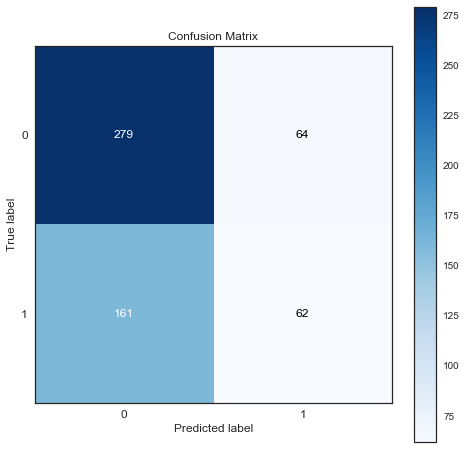

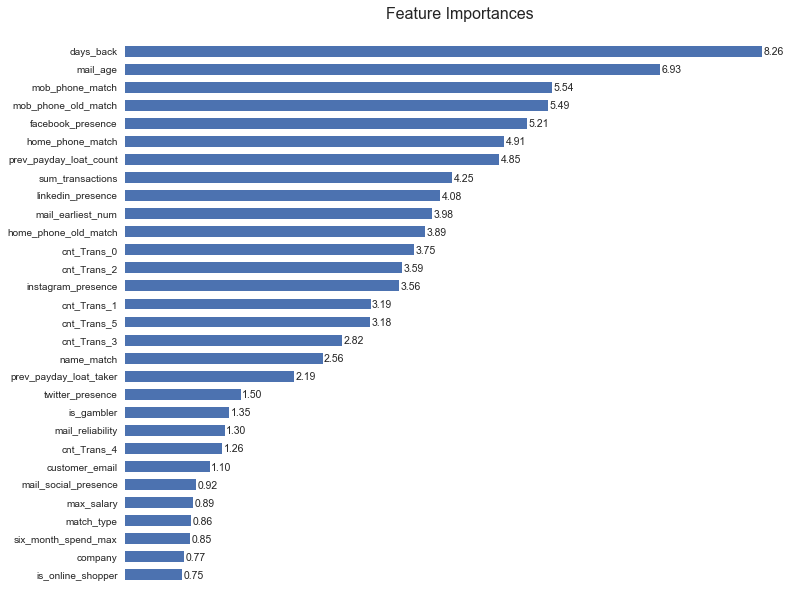

In [169]:
IDF.plot_score(clf, X_test, y_test)

# Reject inference

In [170]:
df_end = pd.concat([df_declined, df_accepted])
df_declined_1, y1, _ = preproc(df_declined)
df_accepted, y2, _ = preproc(df_accepted)
#df_accepted.drop('npl15', axis = 1, inplace = True)
#df_declined_1.drop('npl15', axis = 1, inplace = True)

In [171]:
df_accepted['npl15'] = y2
df_declined_1['npl15'] = pd.DataFrame(clf.predict_proba(df_declined_1)[:, 0], columns=[
                                      'npl15']).npl15.apply(lambda x: np.random.choice([0, 1], p=[1 - x, x]))

In [172]:
df_new_to_train = pd.concat([df_declined_1, df_accepted])
#y_new_to_train = df_new_to_train.npl15
#df_new_to_train.drop('npl15', axis = 1, inplace = True)

In [173]:
df_new_to_train['tt'] = df_new_to_train.credit_id.map(lambda x: train_test(x))
df_train = df_new_to_train[df_new_to_train.tt==1]
df_test = df_new_to_train[df_new_to_train.tt==0]
y_train = df_train.npl15
y_test = df_test.npl15
X_train = df_train.drop(['npl15','credit_id', 'tt'], axis = 1) 
X_test = df_test.drop(['npl15','credit_id', 'tt'], axis = 1) 

In [89]:
#X_train, X_test, y_train, y_test = train_test_split(df_new_to_train, y_new_to_train, test_size=0.33, random_state=1)

In [174]:
clf = CatBoostClassifier(random_seed=42).fit(X_train, y_train)
clf3 = GradientBoostingClassifier(random_state=0,learning_rate = 0.1, max_depth = 5,n_estimators = 100).fit(X_train, y_train)

0: learn: 0.6904413	total: 48.5ms	remaining: 48.4s
1: learn: 0.6880703	total: 94.6ms	remaining: 47.2s
2: learn: 0.6856883	total: 146ms	remaining: 48.5s
3: learn: 0.6837108	total: 196ms	remaining: 48.8s
4: learn: 0.6815566	total: 246ms	remaining: 49s
5: learn: 0.6794531	total: 298ms	remaining: 49.4s
6: learn: 0.6775529	total: 342ms	remaining: 48.5s
7: learn: 0.6757295	total: 387ms	remaining: 47.9s
8: learn: 0.6741449	total: 430ms	remaining: 47.4s
9: learn: 0.672545	total: 483ms	remaining: 47.8s
10: learn: 0.6710965	total: 529ms	remaining: 47.6s
11: learn: 0.6694709	total: 575ms	remaining: 47.4s
12: learn: 0.6680235	total: 626ms	remaining: 47.5s
13: learn: 0.6666437	total: 673ms	remaining: 47.4s
14: learn: 0.6652515	total: 721ms	remaining: 47.3s
15: learn: 0.6641569	total: 771ms	remaining: 47.4s
16: learn: 0.6629852	total: 817ms	remaining: 47.3s
17: learn: 0.6620987	total: 877ms	remaining: 47.9s
18: learn: 0.6610428	total: 930ms	remaining: 48s
19: learn: 0.6601159	total: 980ms	remaining:

ROC_AUC:   0.6377157442670772
Gini:      0.27543148853415444
F1_score:  0.7350233320721402


Classification_report: 
              precision    recall  f1-score   support

          0       0.39      0.61      0.48      3150
          1       0.83      0.66      0.74      8815

avg / total       0.71      0.65      0.67     11965





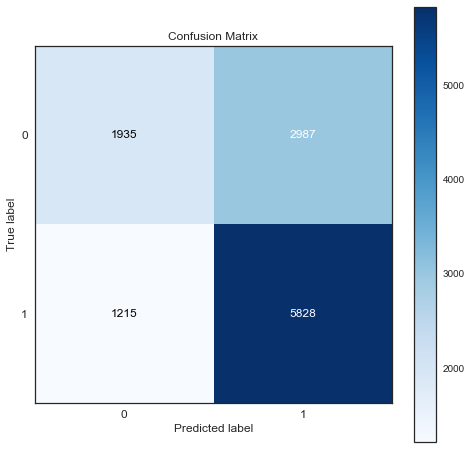

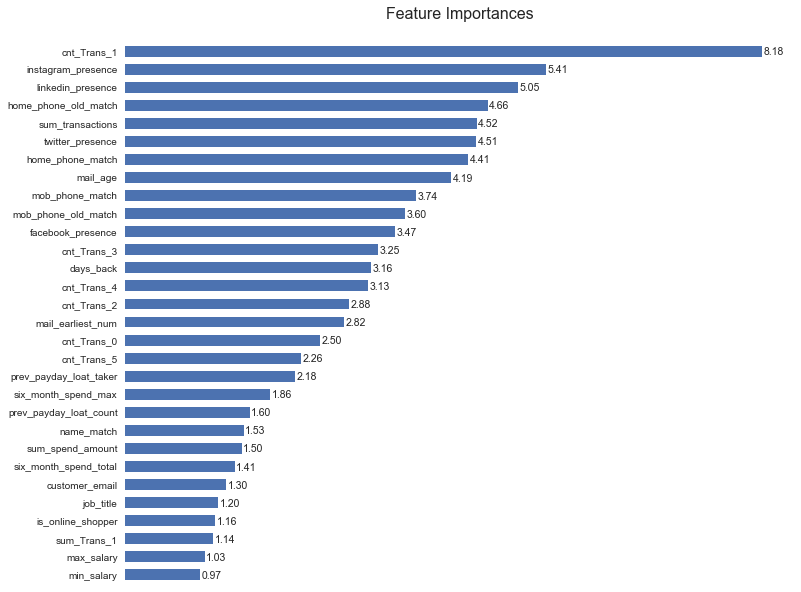

In [176]:
IDF.plot_score(clf, X_test, y_test)

# Export algorithm

In [ ]:
clf = GradientBoostingClassifier(random_state=0, verbose = 0,
                                 learning_rate = 0.1,
                                 max_depth = 3,
                                 n_estimators = 100).fit(df_new_to_train, y_new_to_train) 

In [177]:
from sklearn.externals import joblib
joblib.dump(clf, 'clf_vv_tt_2.pkl');

# Predictions and out

In [119]:
from sklearn.externals import joblib
clf = joblib.load('vv_algorithm_2018_04_11.pkl');

In [93]:
final = df_to_export[['credit_id']]
final['VV_pred_proba'] = clf.predict_proba(X_to_export)[:,1]

In [94]:
writer = pd.ExcelWriter('VV_DATA_2018_04_16.xlsx')
final.to_excel(writer,'VV', index=False)
writer.save()